In [1]:
!pip install vaderSentiment transformers torch pandas matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


# Import Libraries & Load dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = '/content/drive/MyDrive/COMP576/Project/results_with_captions_50.csv'

df = pd.read_csv(dataset_path)
# Remove rows with NaN values in any column
df = df.dropna()

# Reset the index of the cleaned DataFrame
df.reset_index(drop=True, inplace=True)

print(f"Cleaned DataFrame shape: {df.shape}")

Cleaned DataFrame shape: (931, 7)


In [6]:
df

,url,positive_caption,negative_caption,positive_sentiment,negative_sentiment,expected_positive_sentiment,expected_negative_sentiment
0,http://images.cocodataset.org/val2017/00000001...,horse drawn trolley,a horse pulling a trolley,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE
1,http://images.cocodataset.org/val2017/00000038...,a horse in a fenced-in area,a horse in a fenced-in area,POSITIVE,POSITIVE,POSITIVE,NEGATIVE
2,http://images.cocodataset.org/val2017/00000026...,man on skis in the snow,a man on skis in the snow,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE
3,http://images.cocodataset.org/val2017/00000043...,tampa bay rays pitcher david price,tampa bay rays starting pitcher david price th...,POSITIVE,POSITIVE,POSITIVE,NEGATIVE
4,http://images.cocodataset.org/val2017/00000008...,a young skier in the snow,a child on skis in the snow,POSITIVE,POSITIVE,POSITIVE,NEGATIVE
...,...,...,...,...,...,...,...
926,http://images.cocodataset.org/val2017/00000029...,a motorcycle parked on the grass,a motorcycle parked on the grass,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE
927,http://images.cocodataset.org/val2017/00000027...,motorcycles parked on the side of the road,"""motorcycles parked on the side of the road""",POSITIVE,NEGATIVE,POSITIVE,NEGATIVE
928,http://images.cocodataset.org/val2017/00000051...,"""a red biplane flying over a motorcycle""",a man riding a motorcycle next to a red biplane,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE
929,http://images.cocodataset.org/val2017/00000019...,the inside of a bus,the interior of a bus,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE


In [8]:
from tqdm import tqdm
tqdm.pandas()  # Enable progress bar for pandas apply

In [9]:
vader = SentimentIntensityAnalyzer()
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment_vader(text):
    score = vader.polarity_scores(text)['compound']
    if score >= 0.05:
        return "POSITIVE"
    elif score <= -0.05:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

def analyze_sentiment_distilbert(text):
    result = sentiment_pipeline(text)[0]
    return result['label']


# Apply sentiment analysis with progress bars
print("Running VADER Sentiment Analysis on Positive Captions...")
df['vader_positive'] = df['positive_caption'].progress_apply(analyze_sentiment_vader)

print("Running VADER Sentiment Analysis on Negative Captions...")
df['vader_negative'] = df['negative_caption'].progress_apply(analyze_sentiment_vader)

print("Running DistilBERT Sentiment Analysis on Positive Captions...")
df['distilbert_positive'] = df['positive_caption'].progress_apply(analyze_sentiment_distilbert)

print("Running DistilBERT Sentiment Analysis on Negative Captions...")
df['distilbert_negative'] = df['negative_caption'].progress_apply(analyze_sentiment_distilbert)

Running VADER Sentiment Analysis on Positive Captions...


100%|██████████| 931/931 [00:00<00:00, 15456.92it/s]


Running VADER Sentiment Analysis on Negative Captions...


100%|██████████| 931/931 [00:00<00:00, 12180.84it/s]


Running DistilBERT Sentiment Analysis on Positive Captions...


100%|██████████| 931/931 [00:57<00:00, 16.16it/s]


Running DistilBERT Sentiment Analysis on Negative Captions...


100%|██████████| 931/931 [00:56<00:00, 16.49it/s]


In [10]:
vader_pos_acc = accuracy_score(df['expected_positive_sentiment'], df['vader_positive'])
vader_neg_acc = accuracy_score(df['expected_negative_sentiment'], df['vader_negative'])
distil_pos_acc = accuracy_score(df['expected_positive_sentiment'], df['distilbert_positive'])
distil_neg_acc = accuracy_score(df['expected_negative_sentiment'], df['distilbert_negative'])

VADER Positive Accuracy: 0.10
VADER Negative Accuracy: 0.05
DistilBERT Positive Accuracy: 0.48
DistilBERT Negative Accuracy: 0.57


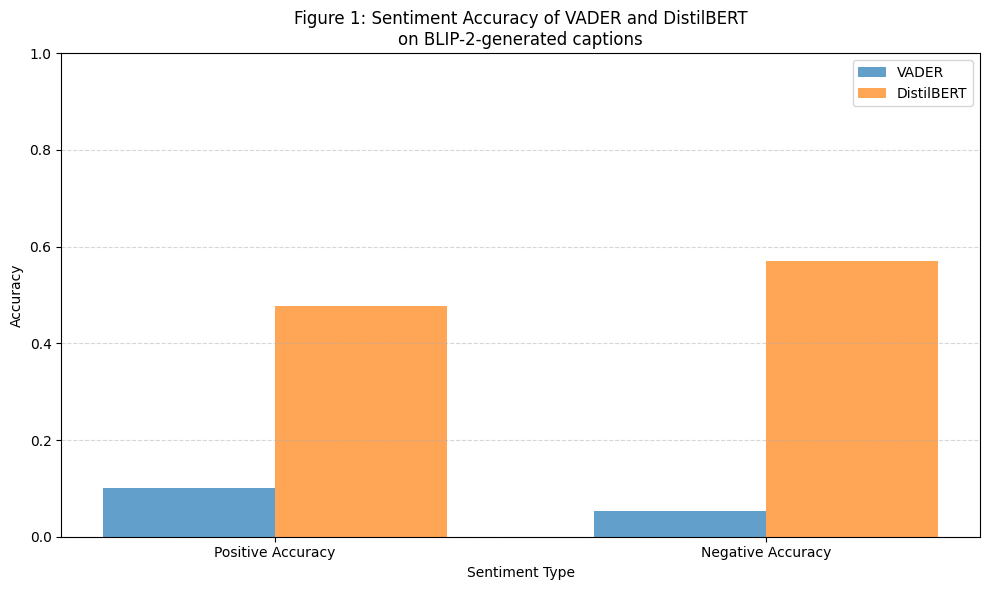

In [12]:
# Print accuracy results
print(f"VADER Positive Accuracy: {vader_pos_acc:.2f}")
print(f"VADER Negative Accuracy: {vader_neg_acc:.2f}")
print(f"DistilBERT Positive Accuracy: {distil_pos_acc:.2f}")
print(f"DistilBERT Negative Accuracy: {distil_neg_acc:.2f}")

# Visualization: Compare accuracies between VADER and DistilBERT
metrics = ['Positive Accuracy', 'Negative Accuracy']
vader_scores = [vader_pos_acc, vader_neg_acc]
distilbert_scores = [distil_pos_acc, distil_neg_acc]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics))

# Plot bars for VADER and DistilBERT
plt.bar(index, vader_scores, bar_width, label='VADER', alpha=0.7)
plt.bar([i + bar_width for i in index], distilbert_scores, bar_width, label='DistilBERT', alpha=0.7)

# Labels and legend
plt.xlabel('Sentiment Type')
plt.ylabel('Accuracy')
plt.title('Figure 1: Sentiment Accuracy of VADER and DistilBERT\non BLIP-2-generated captions')
plt.xticks([i + bar_width/2 for i in index], metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()

In [13]:
df

,url,positive_caption,negative_caption,positive_sentiment,negative_sentiment,expected_positive_sentiment,expected_negative_sentiment,vader_positive,vader_negative,distilbert_positive,distilbert_negative
0,http://images.cocodataset.org/val2017/00000001...,horse drawn trolley,a horse pulling a trolley,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE,NEUTRAL,NEUTRAL,NEGATIVE,NEGATIVE
1,http://images.cocodataset.org/val2017/00000038...,a horse in a fenced-in area,a horse in a fenced-in area,POSITIVE,POSITIVE,POSITIVE,NEGATIVE,NEUTRAL,NEUTRAL,POSITIVE,POSITIVE
2,http://images.cocodataset.org/val2017/00000026...,man on skis in the snow,a man on skis in the snow,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE,NEUTRAL,NEUTRAL,NEGATIVE,POSITIVE
3,http://images.cocodataset.org/val2017/00000043...,tampa bay rays pitcher david price,tampa bay rays starting pitcher david price th...,POSITIVE,POSITIVE,POSITIVE,NEGATIVE,NEUTRAL,NEUTRAL,POSITIVE,POSITIVE
4,http://images.cocodataset.org/val2017/00000008...,a young skier in the snow,a child on skis in the snow,POSITIVE,POSITIVE,POSITIVE,NEGATIVE,NEUTRAL,NEUTRAL,POSITIVE,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...
926,http://images.cocodataset.org/val2017/00000029...,a motorcycle parked on the grass,a motorcycle parked on the grass,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE,NEUTRAL,NEUTRAL,NEGATIVE,NEGATIVE
927,http://images.cocodataset.org/val2017/00000027...,motorcycles parked on the side of the road,"""motorcycles parked on the side of the road""",POSITIVE,NEGATIVE,POSITIVE,NEGATIVE,NEUTRAL,NEUTRAL,POSITIVE,NEGATIVE
928,http://images.cocodataset.org/val2017/00000051...,"""a red biplane flying over a motorcycle""",a man riding a motorcycle next to a red biplane,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE,NEUTRAL,NEUTRAL,NEGATIVE,NEGATIVE
929,http://images.cocodataset.org/val2017/00000019...,the inside of a bus,the interior of a bus,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE,NEUTRAL,NEUTRAL,NEGATIVE,POSITIVE


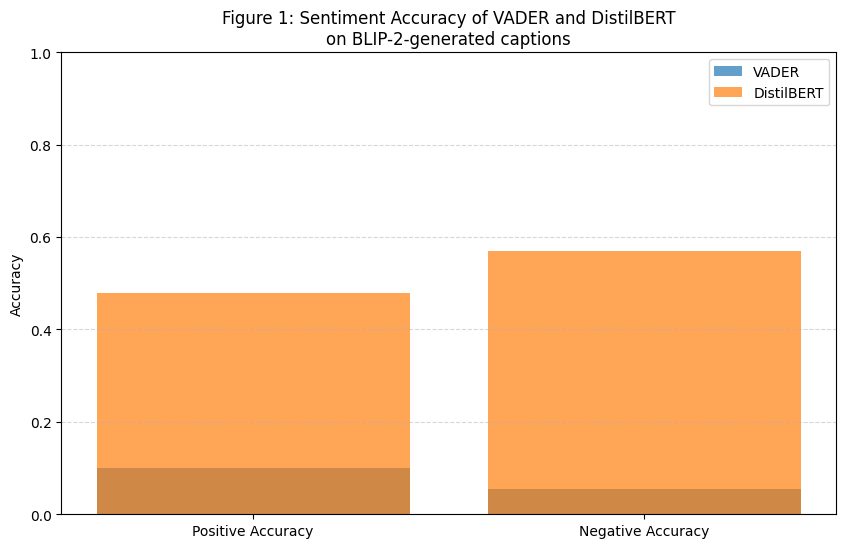

In [11]:
# Figure 1: Sentiment Accuracy Comparison
metrics = ['Positive Accuracy', 'Negative Accuracy']
vader_scores = [vader_pos_acc, vader_neg_acc]
distilbert_scores = [distil_pos_acc, distil_neg_acc]

plt.figure(figsize=(10, 6))
plt.bar(metrics, vader_scores, label='VADER', alpha=0.7)
plt.bar(metrics, distilbert_scores, label='DistilBERT', alpha=0.7)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Figure 1: Sentiment Accuracy of VADER and DistilBERT\non BLIP-2-generated captions')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# Evaluate sentiment classification
def evaluate_sentiment(df):
    # Positive sentiment evaluation
    pos_accuracy = accuracy_score(df['expected_positive_sentiment'], df['positive_sentiment'])
    print(f"Positive Sentiment Accuracy: {pos_accuracy:.2f}")

    # Negative sentiment evaluation
    neg_accuracy = accuracy_score(df['expected_negative_sentiment'], df['negative_sentiment'])
    print(f"Negative Sentiment Accuracy: {neg_accuracy:.2f}")

    # Classification report
    y_true = df['expected_positive_sentiment'].tolist() + df['expected_negative_sentiment'].tolist()
    y_pred = df['positive_sentiment'].tolist() + df['negative_sentiment'].tolist()
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))

In [ ]:
# Remove rows with NaN values in any column
df_50 = df_50.dropna()

# Reset the index of the cleaned DataFrame
df_50.reset_index(drop=True, inplace=True)

print(f"Cleaned DataFrame shape: {df_50.shape}")

Cleaned DataFrame shape: (931, 7)


In [ ]:
len(df_50)
evaluate_sentiment(df_50)

Positive Sentiment Accuracy: 0.48
Negative Sentiment Accuracy: 0.57

Classification Report:

              precision    recall  f1-score   support

    NEGATIVE       0.52      0.57      0.54       931
    POSITIVE       0.53      0.48      0.50       931

    accuracy                           0.52      1862
   macro avg       0.52      0.52      0.52      1862
weighted avg       0.52      0.52      0.52      1862



# Evaluate

In [ ]:
from sklearn.metrics import classification_report, accuracy_score


# Text similarity evaluation (Optional: Using cosine similarity or Jaccard similarity)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def text_similarity(df):
    vectorizer = TfidfVectorizer()
    similarities = []

    for _, row in df.iterrows():
        positive_vector = vectorizer.fit_transform([row['positive_caption']])
        negative_vector = vectorizer.transform([row['negative_caption']])
        sim = cosine_similarity(positive_vector, negative_vector)[0, 0]
        similarities.append(sim)

    df['caption_similarity'] = similarities
    avg_similarity = df['caption_similarity'].mean()
    print(f"\nAverage Caption Similarity (Positive vs Negative): {avg_similarity:.2f}")

# Run evaluations
evaluate_sentiment(df_50)
text_similarity(df_50)

# Inspect mismatches
mismatched = df_50[
    (df_50['positive_sentiment'] != df_50['expected_positive_sentiment']) |
    (df_50['negative_sentiment'] != df_50['expected_negative_sentiment'])
]
print("\nMismatched Rows:\n")
print(mismatched)

Positive Sentiment Accuracy: 0.48
Negative Sentiment Accuracy: 0.57

Classification Report:

              precision    recall  f1-score   support

    NEGATIVE       0.52      0.57      0.54       931
    POSITIVE       0.53      0.48      0.50       931

    accuracy                           0.52      1862
   macro avg       0.52      0.52      0.52      1862
weighted avg       0.52      0.52      0.52      1862


Average Caption Similarity (Positive vs Negative): 0.84

Mismatched Rows:

                                                   url  \
0    http://images.cocodataset.org/val2017/00000001...   
1    http://images.cocodataset.org/val2017/00000038...   
2    http://images.cocodataset.org/val2017/00000026...   
3    http://images.cocodataset.org/val2017/00000043...   
4    http://images.cocodataset.org/val2017/00000008...   
..                                                 ...   
925  http://images.cocodataset.org/val2017/00000005...   
926  http://images.cocodataset.org/val20

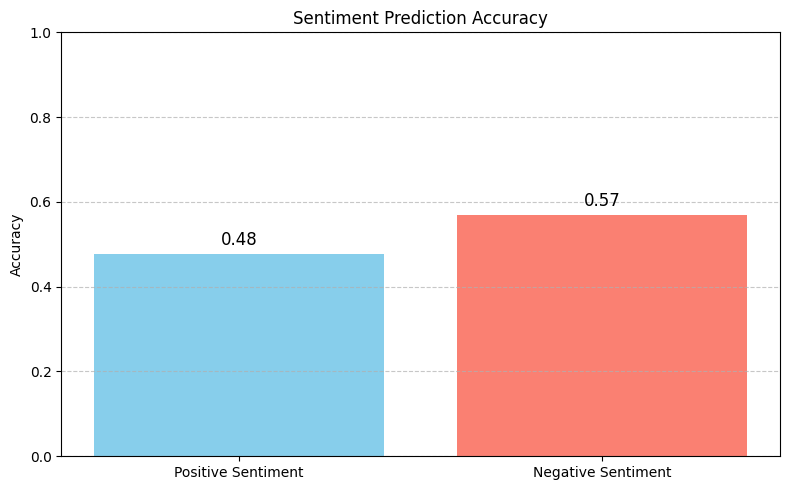

In [ ]:
import matplotlib.pyplot as plt

def plot_sentiment_accuracy(df):
    pos_accuracy = accuracy_score(df['expected_positive_sentiment'], df['positive_sentiment'])
    neg_accuracy = accuracy_score(df['expected_negative_sentiment'], df['negative_sentiment'])

    # Data for plotting
    categories = ['Positive Sentiment', 'Negative Sentiment']
    accuracies = [pos_accuracy, neg_accuracy]

    # Create a bar plot
    plt.figure(figsize=(8, 5))
    plt.bar(categories, accuracies, color=['skyblue', 'salmon'])
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.title('Sentiment Prediction Accuracy')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add accuracy labels on bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot sentiment accuracy
plot_sentiment_accuracy(df_50)


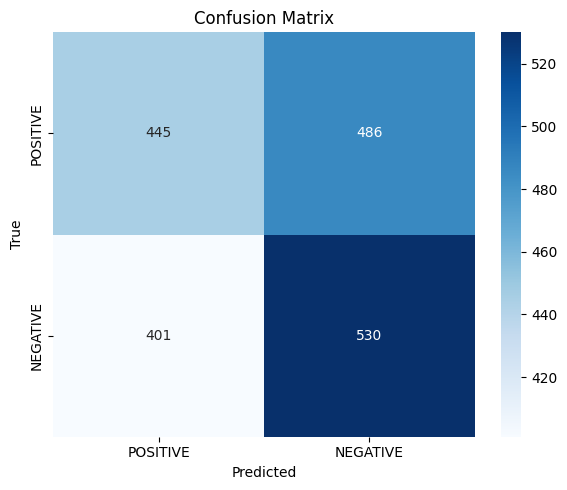

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(df):
    y_true = df['expected_positive_sentiment'].tolist() + df['expected_negative_sentiment'].tolist()
    y_pred = df['positive_sentiment'].tolist() + df['negative_sentiment'].tolist()
    cm = confusion_matrix(y_true, y_pred, labels=['POSITIVE', 'NEGATIVE'])

    # Create a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEGATIVE'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(df_50)

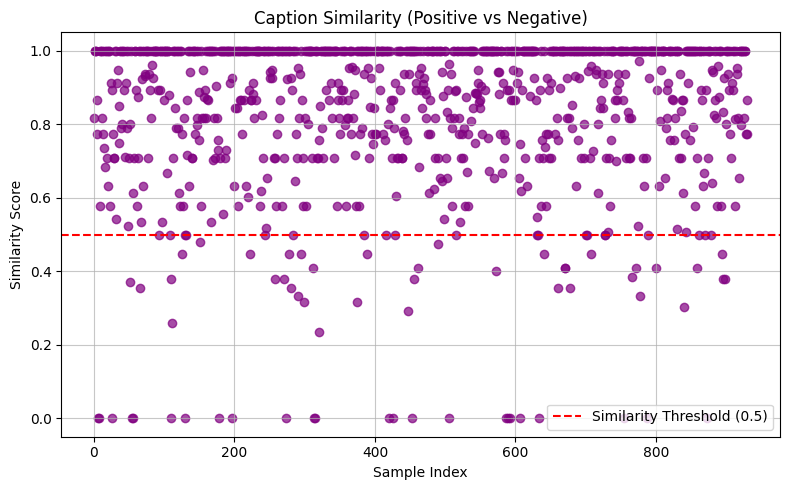

In [ ]:
def plot_caption_similarity(df):
    vectorizer = TfidfVectorizer()
    similarities = []

    for _, row in df.iterrows():
        positive_vector = vectorizer.fit_transform([row['positive_caption']])
        negative_vector = vectorizer.transform([row['negative_caption']])
        sim = cosine_similarity(positive_vector, negative_vector)[0, 0]
        similarities.append(sim)

    df['caption_similarity'] = similarities

    # Scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(df)), df['caption_similarity'], color='purple', alpha=0.7)
    plt.axhline(y=0.5, color='r', linestyle='--', label='Similarity Threshold (0.5)')
    plt.xlabel('Sample Index')
    plt.ylabel('Similarity Score')
    plt.title('Caption Similarity (Positive vs Negative)')
    plt.legend()
    plt.grid(alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot caption similarity
plot_caption_similarity(df_50)


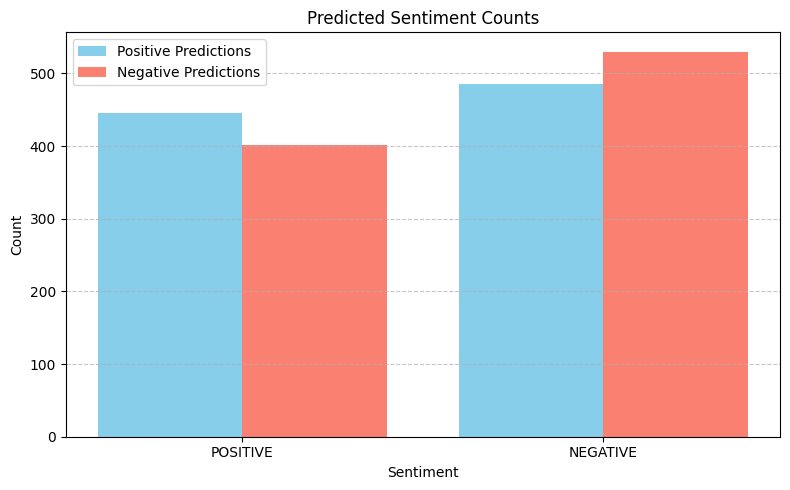

In [ ]:
def plot_sentiment_counts(df):
    pos_count = df['positive_sentiment'].value_counts()
    neg_count = df['negative_sentiment'].value_counts()

    # Data for plotting
    categories = ['POSITIVE', 'NEGATIVE']
    pos_values = [pos_count.get('POSITIVE', 0), pos_count.get('NEGATIVE', 0)]
    neg_values = [neg_count.get('POSITIVE', 0), neg_count.get('NEGATIVE', 0)]

    x = range(len(categories))  # X positions

    # Plot bars
    plt.figure(figsize=(8, 5))
    plt.bar(x, pos_values, width=0.4, label='Positive Predictions', color='skyblue', align='center')
    plt.bar([p + 0.4 for p in x], neg_values, width=0.4, label='Negative Predictions', color='salmon', align='center')

    # Customize plot
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Predicted Sentiment Counts')
    plt.xticks([p + 0.2 for p in x], categories)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot sentiment counts
plot_sentiment_counts(df_50)


In [ ]:
df_50.tail()

,url,positive_caption,negative_caption,positive_sentiment,negative_sentiment,expected_positive_sentiment,expected_negative_sentiment,caption_similarity
926,http://images.cocodataset.org/val2017/00000029...,a motorcycle parked on the grass,a motorcycle parked on the grass,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE,1.000000
927,http://images.cocodataset.org/val2017/00000027...,motorcycles parked on the side of the road,"""motorcycles parked on the side of the road""",POSITIVE,NEGATIVE,POSITIVE,NEGATIVE,1.000000
928,http://images.cocodataset.org/val2017/00000051...,"""a red biplane flying over a motorcycle""",a man riding a motorcycle next to a red biplane,NEGATIVE,NEGATIVE,POSITIVE,NEGATIVE,0.774597
929,http://images.cocodataset.org/val2017/00000019...,the inside of a bus,the interior of a bus,NEGATIVE,POSITIVE,POSITIVE,NEGATIVE,0.866025
930,http://images.cocodataset.org/val2017/00000007...,cats in the living room,a cat and a chair in a living room,POSITIVE,POSITIVE,POSITIVE,NEGATIVE,0.774597


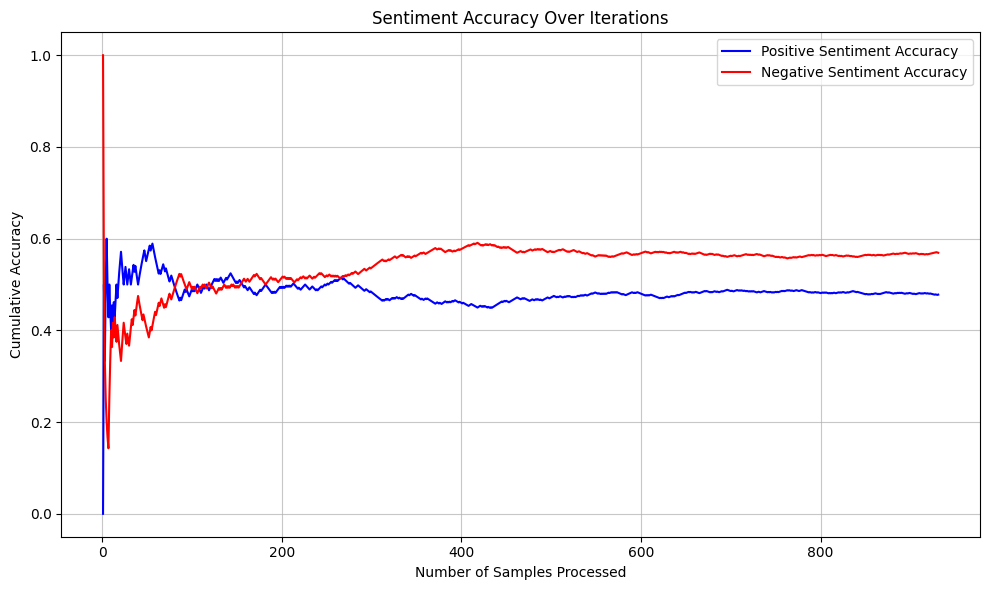

In [ ]:
def plot_accuracy_over_iterations(df):
    cumulative_pos_accuracy = []
    cumulative_neg_accuracy = []

    for i in range(1, len(df) + 1):
        sub_df = df.iloc[:i]
        cumulative_pos_accuracy.append(accuracy_score(sub_df['expected_positive_sentiment'], sub_df['positive_sentiment']))
        cumulative_neg_accuracy.append(accuracy_score(sub_df['expected_negative_sentiment'], sub_df['negative_sentiment']))

    # Line plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(df) + 1), cumulative_pos_accuracy, label='Positive Sentiment Accuracy', color='blue')
    plt.plot(range(1, len(df) + 1), cumulative_neg_accuracy, label='Negative Sentiment Accuracy', color='red')

    # Customize plot
    plt.xlabel('Number of Samples Processed')
    plt.ylabel('Cumulative Accuracy')
    plt.title('Sentiment Accuracy Over Iterations')
    plt.legend()
    plt.grid(alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot accuracy over iterations
plot_accuracy_over_iterations(df_50)
